In [91]:
#IEC DATA RETRIEVAL

import urllib.request
import xml.etree.cElementTree as ET

baseurl = "https://opendata-api.iec.ch/v1/opendata/iev"
token = '00588d84-e45a-442d-ad6a-09a9215ac6aa'
numbers = ['112','151','411','426','436', '441'] #'448']#,'461'] #'442'
# Create list of attributes based on parent xml tags

def create_list_attrib(root, attribute_name):
    attribute_list = []
    for node in root.iter(attribute_name):
        attribute = node.attrib
        attribute_list.append(attribute)
    return attribute_list

# Create list of attributes based on values of xml tags
def create_list_text(root, attribute_name):
    attribute_list = []
    for node in root.iter(attribute_name):
        attribute = node.text
        attribute_list.append(attribute)
    return attribute_list

def create_dataframe(attributes):
    dataframe = {'concept ievref' : attributes[0], 'term-name' : attributes[1],
                 'definition' : attributes[2], 'language id' : attributes[3]}
    return pd.DataFrame(dataframe)  

def parse_xml(url):
    tree = ET.parse(urllib.request.urlopen(url))
    root = tree.getroot()
    
    attributes = []
    attributes = [create_list_attrib(root,'concept'), create_list_text(root,'term-name'), 
                  create_list_text(root, 'definition'), create_list_attrib(root,'lang-set')]
    df = create_dataframe(attributes)
    return df

# df_list = []
# for number in numbers:
#     url = baseurl + '/' + number + '/' + token
#     df_list.append(parse_xml(url))
# final_df = pd.concat(df_list)

In [1]:
# Import dataset
import numpy as np
import pandas as pd
import datetime
# Cosine 
from scipy import spatial
# KNN & TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
# spacy
import spacy
nlp = spacy.load('en_core_web_lg')
# Gensim
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
# Plotting tools
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#data importing
def read_trim():
    df = pd.read_excel ('koiosDatabase_Concepts_and_Definitions.xlsx')
    usefulAttributes = ['CONCEPT_ID', 'TERM_ID', 'DEFINITION_ID' ,'DEFINITION_CONTENT_ID','SYNONYMS_ID', 
    'CONCEPT_TYPE_ID', 'SYNONYM_VALUE', 'DEFINITION','DEF_FULL_SOURCE_TEXT','TERM_SOURCE_ID']
    for x in df.columns.values:
        if x not in usefulAttributes:
            df.drop(x, 1, inplace=True)  
    return df

In [67]:
#tokenizing a description
#return list of "cleaned" words
def remove_punct_stop(description):
    low = [str(t) for t in nlp(description) if t.is_alpha and not t.is_stop]
    return low

#create a dictionary of terms
def term_concepts(df):
    # passed as a list of lists of words for gensim bigram
    descriptions = []
    
    keys = set(df['SYNONYM_VALUE'])
    term_to_concepts = dict.fromkeys(keys)

    count = 0
    for index, row in df.iterrows():
        if count >-1 :
            count = count +1
            term = row['SYNONYM_VALUE']
            concept_id = row['CONCEPT_ID']
            concept_type = row['CONCEPT_TYPE_ID']
            definition = row['DEFINITION']
            
            descriptions.append(remove_punct_stop(definition))

            if term_to_concepts[term] == None:
                term_to_concepts[term] = {}

            #use concept id as keys for the dictionary of each term
            term_to_concepts[term][concept_id] = (concept_type, definition)
        
    return term_to_concepts, descriptions

In [4]:
#delete terms with only one concept
def deletekeys(term_to_concepts):
    for x in list(term_to_concepts.keys()):
        if len(term_to_concepts[x]) == 1: #len(
            del term_to_concepts[x]

In [5]:
#train and return the bigram generator
def trainBigram(description, min_count, threshold):
    phrases = Phrases(description, min_count = min_count, threshold = threshold)
    bigram = Phraser(phrases)
    return bigram

#used for topic modelling
def lemmatization(text):
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
    doc = nlp(" ".join(text))
    returnnewtext = [t.lemma_ if t.lemma_ not in ['-PRON-'] 
                     else '' for t in doc if t.pos_ in allowed_postags]
    return returnnewtext

#removes stopwords and punctuations from each description
#return a list of cleaned descriptions
#generate lists of words for tfidf and topic modelling
def cleared_text_lists(term_to_concepts, bigram):
    tfidf_text = []
    topicmodel_text = []   
    
    for term in list(term_to_concepts.keys()):
        for concept in list(term_to_concepts[term]):
            t, d = term_to_concepts[term][concept]
            desc = bigram[remove_punct_stop(d)]
            
            #call lemmatization for the word list used in Topic Modelling
            topicmodel_text.append(lemmatization(desc))
    
            tfidf_list = ' '.join(desc)
            tfidf_text.append(tfidf_list)
            
    return tfidf_text, topicmodel_text

In [34]:
#METHODS TESTER


text = "A set of triple-in-line package x ray with image plane like a mf outline styles with through-hole leads in standard form of which each outline style can be described with the same group of data element types"
text2 = "A random sentence with meaningless words in it just to check my brain x ray New YORK"
foo_dictionary = {1:{1:("foo",text), 2:("foo2", text2)}}

l1, l2 = cleared_text_lists(foo_dictionary, trainBigram(description,1,1))

print(l1)
print('*********************')
print(l2)
# print(cleared_text_list(foo_dictionary))
# # l = [test, ]
# # b = preprocess_text(text,1,1)
# #print(b)

['set_triple line_package x_ray image_plane like mf outline_styles hole_leads standard_form outline_style described_group data_element types', 'random sentence meaningless words check brain x_ray New YORK']
*********************
[['image_plane', 'outline_style', 'hole_lead', 'standard_form', 'outline_style', 'described_group', 'data_element', 'type'], ['random', 'sentence', 'meaningless', 'word', 'check', 'brain']]


In [6]:
# method for training the tf-idf on all of the descriptions
def trainer(l):
    tfidf = TfidfVectorizer(ngram_range = (1,1), max_df = 1000 )
    tfidf.fit(l)
    return tfidf

#train tfidf on descriptions associated with a single term
# def trainer_w_term(term):
#     text = []
#     for concept in list(term_to_concepts[term]):
#             t, d = term_to_concepts[term][concept]
#             d = ' '.join([str(t) for t in nlp(d) if not t.is_stop | t.is_punct ])
#             text.append(d)
#     tfidf = TfidfVectorizer(ngram_range = (1,2))
#     tfidf.fit(text)
#     return tfidf

# Nearest Neighbours training method
def knn_trainer(tfidf,l):
    samples = []
    descriptions = []
    
    for d in l:
        v = tfidf.transform([d]).toarray()
        samples.append(v[0])
        descriptions.append(d)
    
    s = np.array(samples)
    print(s.shape)
    
    nn = NearestNeighbors(metric = 'cosine')
    nn.fit(s)
    
    return nn, descriptions

#return method for KNN
def return_top_k(k, d,nn, tfidf, bigram):  
    sentence =' '.join(bigram[remove_punct_stop(d)])
    v = tfidf.transform([sentence]).toarray()
    return nn.kneighbors([v[0]],n_neighbors = k)
     

In [7]:
#RADU'S TFIDF and KNN Pipeline
def tfidf_knn(l1, bigram, text,k):
    
    #call the tfidf trainer method, return a trained tfidf
    print("STARTED training TF-IDF AT: ",datetime.datetime.now())
    tfidf = trainer(l1)
    
    
    print("FINISHED training TF-IDF AT: ",datetime.datetime.now())
    
    #call the knn trainer method, return a trained knn and adjacent list of descriptions
    #in order to visualise the results
    print("STARTED training KNN AT: ", datetime.datetime.now())
    knn, ds = knn_trainer(tfidf,l1)
    print("FINISHED training KNN AT: ",datetime.datetime.now())

    #call the method to return the top k -first parameter- most similar
    #descriptions to the one passed as the second parameter
    print("RETURN results for example: ", datetime.datetime.now())
    top = return_top_k(5,text, knn, tfidf, bigram)
    print("Finished at: ", datetime.datetime.now())

    #visualise the results
    x,pos = top
    print(top)
    for i in pos[0]:
        print(ds[i])

In [57]:
# Step 3: Topic Modelling - LDA Online Training

# Create document-term matrix from preprocessed text(tokenize words, remove stopwords, creating bigrams, and word lemmatization)
def prepare_corpus(preprocessedDescription):
    # Create Dictionary
    dictionary = corpora.Dictionary(preprocessedDescription)
    
    # Create corpus
    texts = preprocessedDescription
    
    # Term Document Frequency
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    return dictionary,corpus

# Build the LDA - Online Learning Topic Model
def create_lda_model(preprocessedDescription, nr_topics):
    dictionary, corpus = prepare_corpus(preprocessedDescription)

    # Online LDA training - processes the whole corpus in one pass, then updates the model, then another pass and so on (Faster Execution)
    #lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=nr_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=False)
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=nr_topics, random_state=100,passes=10)
    # Different methods of printing key topics and associated key words with scores
    print(lda_model.print_topics())
    #print(lda_model.top_topics(document_term_matrix, dictionary, coherence = 'c_v', topn = words))
    #for i, topic in lda_model.show_topics(formatted=True, num_topics = 10, num_words = 5):
        #print(str(i) +": "+ topic)
        #print()

    return lda_model

# Compute perplexity score and coherence score - performance measurement metrics that give an indication of how good the topic model is
def compute_perplexity_coherence(data_lemmatized, lda_model, corpus, dictionary):
    print('\n Perplexity: ', lda_model.log_perplexity(corpus))

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\n Coherence Score: ', coherence_lda)

# Compute cohrerence scores for multiple trained lda models and compute corresponding coherence scores to determine optimal number of topics
def compute_coherence_values(dictionary, corpus, preprocessedDescriptions, limit, start=2, step=3):
    # dictionary: Gensim dictionary
    # corpus: Gensim corpus
    # preprocessedDescriptions: list of processed descriptions
    # limit: maximum number of topics
    
    coherence_values = []
    model_list = []
    
    for numberTopics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics = numberTopics, id2word = dictionary, passes = 1)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts = preprocessedDescriptions, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

# Plot the above results in the form of a line graph.
def plot_graph(preprocessedDescription, start, limit, step):
    dictionary, corpus = prepare_corpus(preprocessedDescription)
    model_list, coherence_values = compute_coherence_values(dictionary, corpus, preprocessedDescription, limit, start, step)
    
    x = range(start, limit, step)
    plt.plot(x,coherence_values)
    #plt.xticks(x)
    plt.xlabel("Number of topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc = 'best')
    plt.show()
    
    for m, cv in zip(x, coherence_values):
        print("Number of Topics =", m, " has Coherence Value of", round(cv, 4))

In [19]:
#Abhi's Topic Modelling using LDA (Online Training)

def topic_modelling(l2, nr_topics):
    # Method call - prepare_corpus
    dictionary, corpus = prepare_corpus(l2)
    print(corpus[:1])

    # Human readable format of corpus (term-frequency) - Understanding the document-term matrix
    [[(dictionary[id], freq) for id, freq in corp] for corp in corpus[:1]]

    # Method call - lda model creation and training
    lda_model = create_lda_model(l2, nr_topics)

    # Method call - perplexity/coherence score computation
    compute_perplexity_coherence(l2, lda_model, corpus, dictionary)

    # Visualise potential optimum number of topics to determine the diversity of topics and identify closely similar topics, that can be merged into one large topic
    lda_model = create_lda_model(l2, nr_topics)
    dictionary,corpus = prepare_corpus(l2)
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    vis
    
    # Method call - plotting coherence score vs. number of topics
    start,limit,step = 2,50,5
    plot_graph(l2, start, limit, step) 

STAGE I
Term-Concept Dictionary is being loaded...
Bigram model is being trained...
Deleting keys
Generate Lists
STAGE II
STARTED training TF-IDF AT:  2019-07-12 09:32:47.206367
FINISHED training TF-IDF AT:  2019-07-12 09:32:47.570395
STARTED training KNN AT:  2019-07-12 09:32:47.572389
(14546, 42751)
FINISHED training KNN AT:  2019-07-12 09:33:07.665674
RETURN results for example:  2019-07-12 09:33:07.668667
Finished at:  2019-07-12 09:33:14.351764
(array([[0.        , 0.06330064, 0.16272488, 0.16627324, 0.17544681]]), array([[ 9231, 11518,  9234,  9233,  9235]], dtype=int64))
set_triple line_package outline_styles hole_leads standard_form outline_style described_group data_element types
set_triple line_package outline_styles hole_leads outline_style described_group data_element types
set_quad line_package outline_styles hole_leads standard_form outline_style described_group data_element types
set_dual line_package outline_styles hole_leads standard_form outline_style described_group 

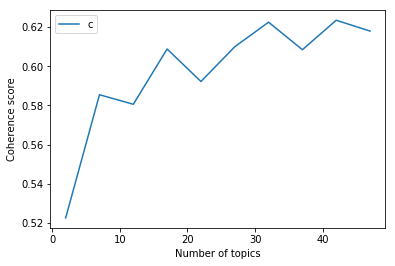

Number of Topics = 2  has Coherence Value of 0.5226
Number of Topics = 7  has Coherence Value of 0.5854
Number of Topics = 12  has Coherence Value of 0.5806
Number of Topics = 17  has Coherence Value of 0.6088
Number of Topics = 22  has Coherence Value of 0.5922
Number of Topics = 27  has Coherence Value of 0.6099
Number of Topics = 32  has Coherence Value of 0.6224
Number of Topics = 37  has Coherence Value of 0.6084
Number of Topics = 42  has Coherence Value of 0.6234
Number of Topics = 47  has Coherence Value of 0.6179


In [13]:
def main():
    
   #STAGE I - initialise the dataframes, dictionaries, bigrams and list
    print("STAGE I")
    df = read_trim()
    print("Term-Concept Dictionary is being loaded...")
    term_to_concepts, description = term_concepts(df)
    print("Bigram model is being trained...")
    bigram = trainBigram(description,1,1)
    print("Deleting keys")
    deletekeys(term_to_concepts)
    print("Generate Lists")
    l1, l2 = cleared_text_lists(term_to_concepts, bigram)
    
   #STAGE II - Tfidf
    print("STAGE II")
    k = 5
    text = "A set of triple-in-line package outline styles with through-hole leads in standard form of which each outline style can be described with the same group of data element types"
    tfidf_knn(l1,bigram,text,k)
    
   #StageIII - Topic Modelling
    print("STAGE III")
    topic_modelling(l2)

    
if __name__ == "__main__":
    main()

In [232]:
# return a scipy sparse matrix representing the tfidf weight for each term of each document
# have to convert into corpus to be loaded for lda model
inverse =tfidf.fit_transform(l1)
print(inverse)

In [223]:
#KNN trainer for topic modelling
# numpy array used to store the scores each description has for each topic

import numpy
def KNN_trainer_topicModelling(lda_model, corpus, no_topics):  
    no_descriptions = len(corpus)
    features = numpy.empty(shape=(no_descriptions,no_topics))
    
    x = 0

    for sentence in corpus:
        #print(sentence)
        numbers = numpy.zeros(no_topics)
        #print(len(numbers))
        values = lda_model[sentence]
        #print(values)
        for tuples in values:
            topic, score = tuples
            numbers[topic] = score
        features[x] = numbers
        x = x + 1

    nn_topic = NearestNeighbors(metric = 'l2')#(metric = 'euclidean')
    nn_topic.fit(features)
    
    return nn_topic


In [237]:
#running the KNN trainer for topic modelling
nn = KNN_trainer_topicModelling(lda_model, corpus, 5)

#simulate a new text given as input to the KNN model
text = "A set of triple-in-line package outline styles with through-hole leads in standard form of which each outline style can be described with the same group of data element types"
text_vec = dictionary.doc2bow(bigram[remove_punct_stop(text)])

#preprocess the new text
processed = numpy.zeros(5)
for tuples in lda_model[text_vec]:
    topic, score = tuples
    processed[topic] = score
    
#reshape for fitting the kneighbors method for nn
new = np.reshape(processed, (1,-1))
top = nn.kneighbors(new, n_neighbors = 5)    

x,pos = top
print(top)
for i in pos[0]:
    print(ds[i])
    print("************************************************************************")

In [225]:
#check the indexes directly from the corpus
for x in [11445, 12917, 12918, 10982, 11968]:
    for t in corpus[x]:
        i, c = t
        print(dictionary[i], sep=' ', end=' ', flush=True)
    print()    
    print("*********************")

n_garment construction_body measurement_build select_appropriately sized_garment sizing_system 
*********************
angles_iso lines_right measured_pair showing_relation typically_variable variable_quantitie 
*********************
angles_iso lines_right measured_pair showing_relation typically_variable variable_quantitie 
*********************
n_petroleum changed_originally manufactured_suitable oil_characteristic product_recycle recycling 
*********************
appearance dyed_fiber n_blend naturally_colored overall_gray white_fiber 
*********************
